In [1]:
# !pip install mlxtend
# !pip install xgboost
# pip install -U imbalanced-learn
# conda install -c glemaitre imbalanced-learn
# !conda install -c conda-forge imbalanced-learn -y
# !pip install yellowbrick

<a class="anchor" id="TOC"></a>

# Table of Contents

### Accessing and preprocessing Data
[Connect to Database](#connect_database)

[Data Processing](#data_preprocessing)

[Churn Analysis](#churn)

[EDA](#eda)

[Saving Processed Pickled File - for modeling](#pickle)

### Base Model, Oversampling and Feature Selection
[Functions for Metrics](#function_metric)

[Baseline Model](#baseline_model)

[Oversampling to Deal with Class Imbalance](#class_imbalance)

[Feature Selection with Trees](#FS_tree)

[Feature Selection with Lasso](#FS_lasso)

[Feature Selection with Ridge](#fs_ridge)

[Feature Selection with Base Model - seeing impact](#FS_with_base)

### Model Selection

[Model Selection - among 10 models](#model_ten)

[Further Model Selection with ROC AUC Curves](#model_roc)

[Test Select (XGBoost) Model](#test_model)

### Saving Model
[Saving Model and running proba](#save_model)

<a class="anchor" id="feature_selection"></a>

In [8]:
import pandas as pd
import numpy as np
import psycopg2 as pg
import csv
import pickle
import time
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from collections import Counter
from collections import defaultdict
from statistics import mean
import copy
import matplotlib.dates as mdates

from sklearn import linear_model, naive_bayes, svm, neural_network
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, LassoCV, Lasso
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, precision_recall_curve,f1_score, fbeta_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.model_selection import KFold, GridSearchCV

from yellowbrick.datasets import load_occupancy
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%config InlineBackend.figure_format = 'svg'
plt.style.use('fivethirtyeight')

<a class="anchor" id="connect_database"></a>

## Connecting to Twitter database

In [2]:
import sys
try:
    import psycopg2 as pg
except ImportError:
    print("You should install psycopg2 with the command")
    print("conda install psycopg2")
    sys.exit(0)

In [3]:
connection_args = {
    'host': "18.144.33.8",  # You'll have to update this to your IP
    'user': 'postgres',  # username
    'dbname': 'twitter',  # DB that we are connecting to
    'port': 5432  # port we opened on AWS
}

In [4]:
connection = pg.connect(**connection_args)

OperationalError: could not connect to server: Operation timed out
	Is the server running on host "18.144.33.8" and accepting
	TCP/IP connections on port 5432?


In [ ]:
cursor = connection.cursor()

Accessing user database

In [ ]:
cursor.execute("SELECT * FROM final_table")
df = pd.DataFrame(cursor.fetchall())

In [14]:
df.shape

(102978, 49)

In [15]:
df.columns = ['user_id', 'tweet_count', 'latest_post', 'earliest_post','count_posts', 'mean_text_length',
'std_dev_text_length', 'android', 'iphone', 'desktop_web', 'web_app', 'sum_count_reply_screen',
'sum_retweet', 'sum_favorite_count', 'sum_retweet_zero', 'sum_retweet_100', 'sum_retweet_1000',
'sum_retweet_viral', 'len_hashtags', 'len_symbols', 'len_user_mentions', 'days_30', 'days_60',
'days_90', 'days_before_90', 'created_at', 'description', 'length_description', 'favourites_count', 
'followers_count','following_yn', 'friends_count', 'geo_enabled_yn', 'extended_profile_yn', 
'translation_enabled_yn', 'listed_count', 'location_stated_yn', 'location', 'name', 
'length_name', 'notification_yn', 'profile_image_url', 'default_profile_image_yn', 'background_image_yn',
'protected_yn', 'screen_name', 'screen_name_length', 'statuses_count', 'url_yn']

<a class="anchor" id="data_preprocessing"></a>

## Further Processing on Data

[Table of Content](#TOC)

### Convert dates

In [17]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['latest_post'] = pd.to_datetime(df['latest_post'])
df['earliest_post'] = pd.to_datetime(df['earliest_post'])

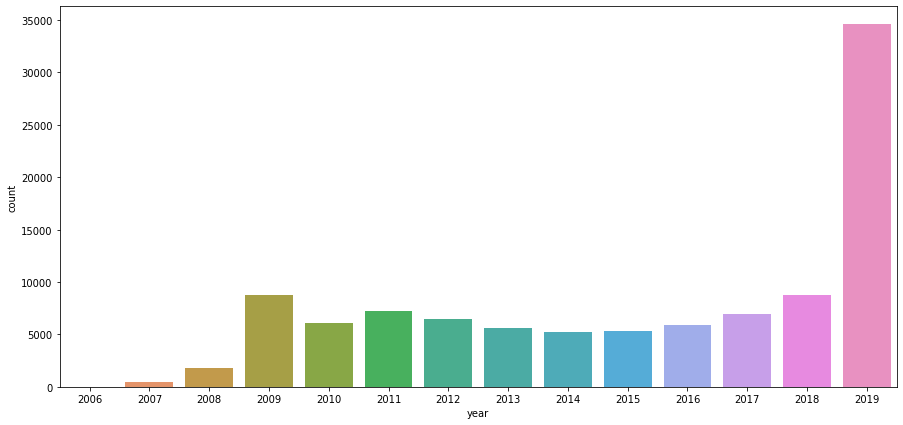

In [19]:
year_dist = df.groupby(df['created_at'].dt.year)['user_id'].count().reset_index()
year_dist.columns = ['year','count']

ax = plt.subplots(figsize=(15,7))
sns.barplot(x='year', y='count', data= year_dist)

The data is skewed towards 2019. Since we're predicting churn, let's get filter data for accounts that were created May 2019 and earlier

In [21]:
df = df[df['created_at'] <= '2019-05-31']

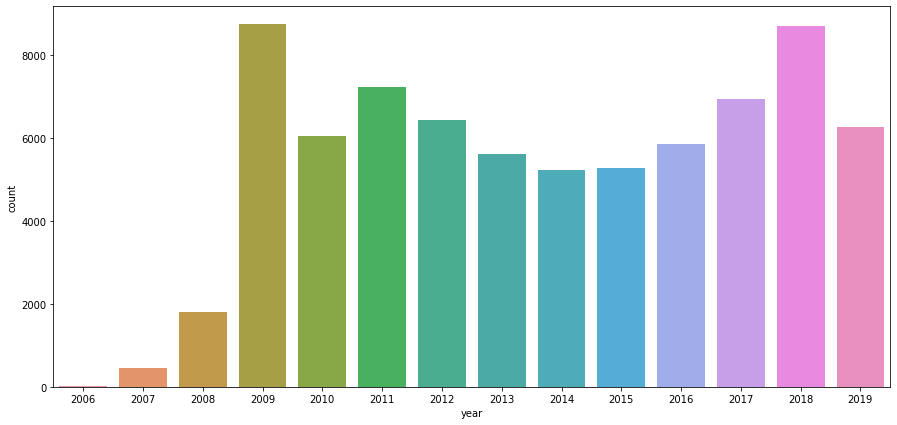

In [22]:
year_dist = df.groupby(df['created_at'].dt.year)['user_id'].count().reset_index()
year_dist.columns = ['year','count']

ax = plt.subplots(figsize=(15,7))
sns.barplot(x='year', y='count', data= year_dist)

In [23]:
# length of dataframe
len(df)

74670

Getting time range

In [24]:
df['time_range'] = (pd.to_datetime(df['latest_post']).dt.date - \
                          pd.to_datetime(df['earliest_post']).dt.date).dt.days

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
# getting frequency of tweets since first to last tweet
df['frequency'] = df['tweet_count'] / df['time_range']
df['frequency'] = df['frequency'].replace(np.inf, 0)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<a class="anchor" id="churn"></a>

## Churn Analysis and Decision

[Table of Content](#TOC)

In [39]:
define_churn = df.copy()
define_churn['year_month_date'] = define_churn['latest_post'].map(lambda x: x.strftime('%Y-%m-%d'))


Define businesses

In [6]:
define_churn['total_devices'] = define_churn['android'] + define_churn['iphone'] + \
                                    define_churn['desktop_web'] + define_churn['web_app']

In [41]:
define_churn['business'] = define_churn[['total_devices','tweet_count']].\
                                apply(lambda x: 1 if x['tweet_count'] * 0.80 > x['total_devices'] else 0, axis=1)

In [36]:
print(define_churn['business'].value_counts())

0    62910
1    11760
Name: business, dtype: int64


In [45]:
# set a date when i collected data
today = date(2019, 10, 29)

# get days since users last posted
define_churn['last_day_post'] = (today - pd.to_datetime(define_churn['latest_post']).dt.date ).dt.days

In [46]:
define_churn = define_churn[define_churn['business'] == 0]

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Class 0: 52756
Class 1: 10154
Proportion: 5.2 :1
Percentage of Majority Class: 83.86


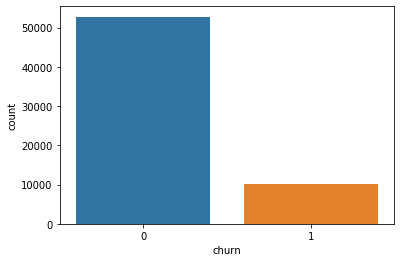

In [47]:
# defining churn
churn_thres = 60
define_churn['churn'] = [1 if x > churn_thres else 0 for x in define_churn['last_day_post']]

target_count = define_churn['churn'].value_counts()

print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0]/target_count[1],2)} :1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')
      
ax = sns.countplot(x='churn', data=define_churn)


Let's add churn label into the main data

In [48]:
merged_df = pd.merge(define_churn[['churn','user_id']], df, how='inner', on='user_id')

<a class="anchor" id="eda"></a>

## EDA

[Table of Content](#TOC)

Some EDA was done in this notebook, but they were mainly uploaded to Tableau for further analysis

In [50]:
merged_df.to_csv('twitter_df.csv')

In [51]:
map_trend = df.copy()
map_trend['year_month_latest_post'] = map_trend['latest_post'].map(lambda x: x.strftime('%Y-%m'))
map_trend = pd.DataFrame(map_trend.groupby('year_month_latest_post')['user_id'].count())                                                                   

In [52]:
# map_trend.reset_index()
map_trend = pd.DataFrame(map_trend.reset_index())

map_trend.columns = ['year_month_latest_post','count_users']

#### Plot last day posted distribution

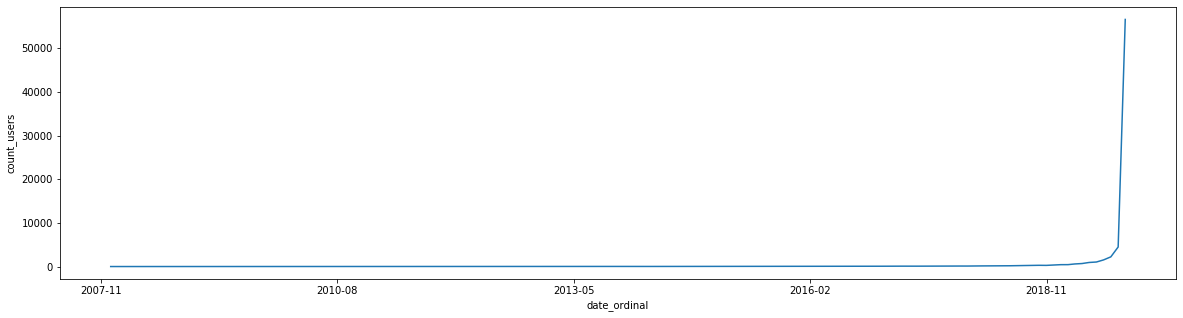

In [53]:
map_trend['date_ordinal'] = pd.to_datetime(map_trend['year_month_latest_post'])
map_trend['date_ordinal'] = map_trend['date_ordinal'].apply(lambda date: date.toordinal())

fig, ax = plt.subplots(figsize=(20,5))

# setting new x labels as we reformat them
new_labels = map_trend['year_month_latest_post']
ax.set_xticklabels(new_labels)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# choosing the lineplot because to plot the trend for us
ax = sns.lineplot(
    data=map_trend,
    x='date_ordinal',
    y='count_users')



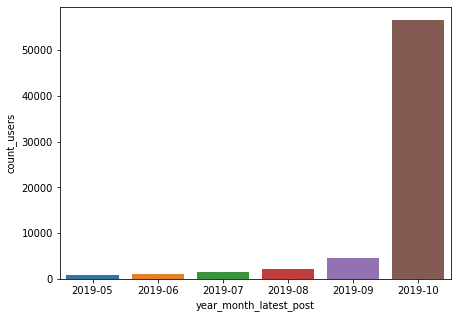

In [54]:
map_recent = map_trend[map_trend['year_month_latest_post'] > '2019-04']

fig, ax = plt.subplots(figsize=(7,5))

# setting new x labels as we reformat them
new_labels = map_recent['year_month_latest_post']
ax.set_xticklabels(new_labels)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# choosing the lineplot because to plot the trend for us
ax = sns.barplot(
    data=map_recent,
    x='year_month_latest_post',
    y='count_users')

<a class="anchor" id="pickle"></a>

## Merging, Saving, Loading Pickled Files

[Table of Content](#TOC)

Cleaning and creating some new features

In [55]:
# let's create an ordinal date column for modelling
merged_df['created_at_ordinal'] = pd.to_datetime(merged_df['created_at'], format='%Y%m%d %H:%M:%S').map(dt.datetime.toordinal)

save file into a pickle

In [5]:
with open('tweepy_api/API_calls/Data/merged_df.pickle','wb') as to_write:
    pickle.dump(merged_df, to_write)

NameError: name 'merged_df' is not defined

### Loading from where we cleaned

In [7]:
with open('tweepy_api/API_calls/Data/merged_df.pickle','rb') as read_file:
    merged_df = pickle.load(read_file)

EOFError: Ran out of input

<a class="anchor" id="function_metric"></a>

## Functions for Metrics

[Table of Contents](#TOC)

In [20]:
# Let's create a quick function to define metrics

def get_metrics(y_val, X_val, model):
    '''
    Arguments
    -----------
    y_val: y validation or test values
    X_val: X validation or test values
    Model: Model that has been fitted on trained values
    
    Returns
    -----------
    - Confusion matrix
    - Precision, Recall and F1 Score
    - ROC AUC score
    - ROC curve
    '''
    print("Confusion Matrix:")
#     cm = ConfusionMatrix(model, classes=['active','churn'])
#     cm.score(X_val, y_val)
#     cm.show()
    print(confusion_matrix(y_val, model.predict(X_val)))

    print("Precision: {:6.4f},   Recall: {:6.4f}, F1 Score: {:6.4f}".\
          format(precision_score(y_val, model.predict(X_val)), 
                 recall_score(y_val, model.predict(X_val)), 
                 f1_score(y_val, model.predict(X_val))))
    
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:,1])

#     fig, ax = plt.subplots(figsize=(20,5))
    fig = plt.figure(figsize = (8,6))
    plt.plot(fpr, tpr,label=type(model).__name__,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.legend()
    plt.grid(False)

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC');
    print("ROC AUC score = ", roc_auc_score(y_val, model.predict_proba(X_val)[:,1]));

In [21]:
def feature_imp(y_val, X_val, model):
    '''
    Arguments
    -----------
    y_val: y validation or test values
    X_val: X validation or test values
    Model: Model that has been fitted on trained values
    
    Returns
    -----------
    feature importance graph
    '''
    fig = plt.figure()
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.grid(False)

    viz = FeatureImportances(model)
    viz.fit(X_val, y_val)
    viz.show()

In [22]:
def precision_recall(y_val, X_val, model):
    '''
    Arguments
    -----------
    y_val: y validation or test values
    X_val: X validation or test values
    Model: Model that has been fitted on trained values
    
    Returns
    -----------
    - Precision and recall curves plotted against thresholds
    - Precision and recall curves plotted against each other
    '''
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, model.predict_proba(X_val)[:,1] )

    plt.figure(dpi=80)
    plt.plot(threshold_curve, precision_curve[1:],label='precision')
    plt.plot(threshold_curve, recall_curve[1:], label='recall')
    plt.legend(loc='lower left')
    plt.xlabel('Threshold (above this probability, label as churn)');
    plt.title('Precision and Recall Curves');
    plt.grid(False) 
    
    plt.figure(dpi=80)
    plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(False);


<a class="anchor" id="baseline_model"></a>

## Baseline Model: Logistic regression

[Table of Contents](#TOC)

In [23]:
merged_df['length_description'] = merged_df['length_description'].fillna(0)
merged_df['length_name'] = merged_df['length_name'].fillna(0)

In [24]:
X = merged_df[['tweet_count', 'mean_text_length', 'android','iphone', 'desktop_web', 'web_app',
               'sum_count_reply_screen','sum_retweet', 'sum_favorite_count', 'sum_retweet_zero',
               'sum_retweet_100', 'sum_retweet_1000', 'sum_retweet_viral', 'len_hashtags', 'len_symbols',
               'len_user_mentions', 'days_30','days_60','notification_yn', 'default_profile_image_yn',
                'background_image_yn', 'protected_yn', 'screen_name_length', 'statuses_count', 'url_yn', 
               'time_range','frequency', 'created_at_ordinal','favourites_count', 'followers_count',
                'following_yn', 'friends_count','geo_enabled_yn','extended_profile_yn', 
                'translation_enabled_yn', 'listed_count', 'location_stated_yn', 'length_name','days_90', 'days_before_90']]
y = merged_df['churn']

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

Fitting Logistic Model

In [102]:
lml = LogisticRegression(solver='liblinear', C = 1000)
lml.fit(X_train, y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Confusion Matrix:
[[8488    2]
 [1576    0]]
Precision: 0.0000,   Recall: 0.0000, F1 Score: 0.0000
ROC AUC score =  0.859758718827166


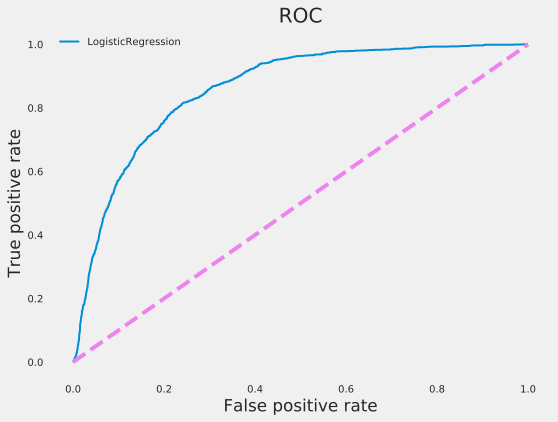

In [103]:
get_metrics(y_val, X_val, lml)

<Figure size 432x288 with 0 Axes>

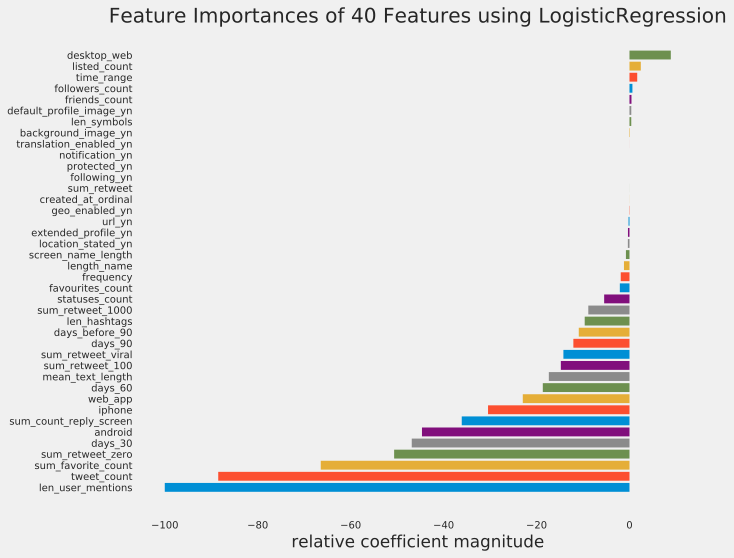

In [104]:
feature_imp(y_val, X_val, lml)

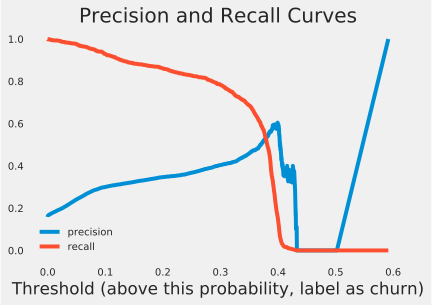

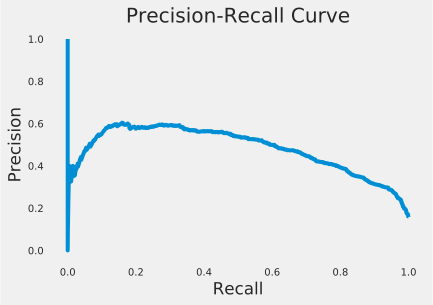

In [105]:
precision_recall(y_val, X_val,lml)

<a class="anchor" id="class_imbalance"></a>

## Oversampling Methods for Class Imbalance

[Table of Contents](#TOC)

Using Adasyn does the best

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'>
Confusion Matrix:
[[5860 2581]
 [ 194 1431]]
Precision: 0.3567,   Recall: 0.8806, F1 Score: 0.5077
ROC AUC score =  0.8751193533394693


<class 'imblearn.over_sampling._smote.SMOTE'>
Confusion Matrix:
[[5860 2581]
 [ 212 1413]]
Precision: 0.3538,   Recall: 0.8695, F1 Score: 0.5029
ROC AUC score =  0.866624406513993


<class 'imblearn.over_sampling._adasyn.ADASYN'>
Confusion Matrix:
[[5815 2626]
 [ 157 1468]]
Precision: 0.3586,   Recall: 0.9034, F1 Score: 0.5134
ROC AUC score =  0.8838579461055471




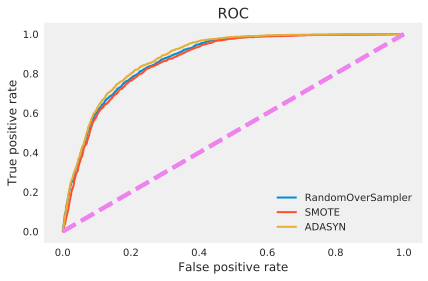

In [16]:
balancing_dict = {'RandomOverSampler': RandomOverSampler, 'SMOTE': SMOTE, 'ADASYN': ADASYN}

# getting X and Y resampled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42,
                                                  stratify=y_train)

# iterating through balancing dict
for bal_key in balancing_dict:
    bal = balancing_dict[bal_key]
    
    # resampling using different balancing techniques
    X_resampled, y_resampled = bal(random_state=42).fit_sample(X_train,y_train)
    
    # Fitting in Logistic regression
    lml = LogisticRegression(solver='liblinear', C = 1000)
    lml.fit(X_resampled, y_resampled)
    
    print(bal)

    print("Confusion Matrix:")
    print(confusion_matrix(y_val, lml.predict(X_val)))

    print("Precision: {:6.4f},   Recall: {:6.4f}, F1 Score: {:6.4f}".\
          format(precision_score(y_val, lml.predict(X_val)), 
                 recall_score(y_val, lml.predict(X_val)), 
                 f1_score(y_val, lml.predict(X_val))))

    fpr, tpr, thresholds = roc_curve(y_val, lml.predict_proba(X_val)[:,1])
    
    
    plt.grid(False)
    plt.plot(fpr, tpr,label=bal.__name__,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.legend()

    plt.savefig('balancing.png',bbox_inches='tight')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC');

    print("ROC AUC score = ", roc_auc_score(y_val, lml.predict_proba(X_val)[:,1]))
    print('\n')
    ;

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42,
                                                  stratify=y_train)

# resampling using ADASYN
X_resampled, y_resampled = ADASYN(random_state=42).fit_sample(X_train,y_train)
    
lml = LogisticRegression(solver='liblinear', C = 1000)
lml.fit(X_resampled, y_resampled)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

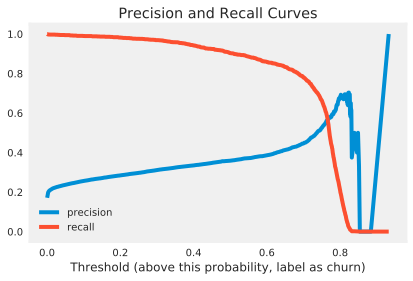

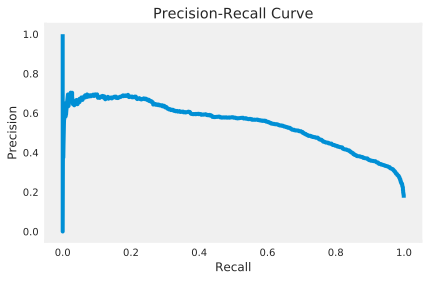

In [18]:
precision_recall(y_val, X_val,lml)

<a class="anchor" id="FS_tree"></a>

## Feature Selection with Random Forest

[Table of Contents](#TOC)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42,
                                                  stratify=y_train)

X_resampled, y_resampled = ADASYN(random_state=42).fit_sample(X_train,y_train)

In [20]:
decisiontree = RandomForestClassifier()

decisiontree.fit(X_resampled, y_resampled)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

<Figure size 432x288 with 0 Axes>

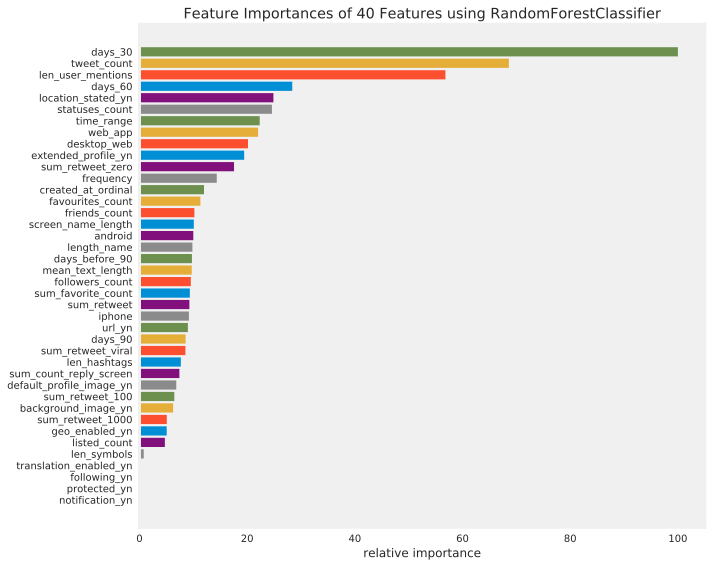

In [21]:
feature_imp(y_val, X_val, decisiontree)

Confusion Matrix:
[[7869  572]
 [ 794  831]]
Precision: 0.5923,   Recall: 0.5114, F1 Score: 0.5489
ROC AUC score =  0.8894731028952094


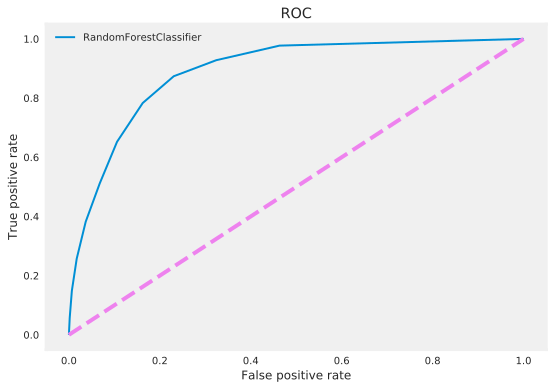

In [22]:
get_metrics(y_val, X_val, decisiontree)

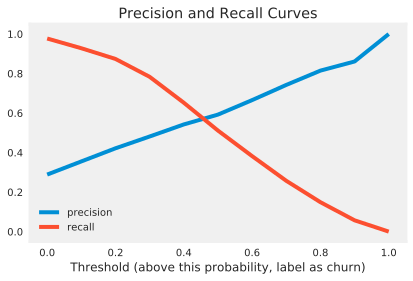

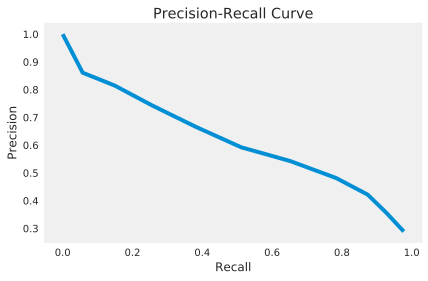

In [23]:
precision_recall(y_val, X_val,decisiontree)

#### Removing some features and seeing results

In [24]:
X_subset2 = ['tweet_count', 'mean_text_length', 'android','iphone', 'desktop_web', 'web_app',
               'sum_count_reply_screen','sum_retweet', 'sum_favorite_count', 'sum_retweet_zero',
               'sum_retweet_100', 'sum_retweet_1000', 'sum_retweet_viral', 'len_hashtags',
               'len_user_mentions', 'days_30','days_60', 'default_profile_image_yn',
                'background_image_yn', 'screen_name_length', 'statuses_count', 'url_yn', 
               'time_range','frequency', 'created_at_ordinal','favourites_count', 'followers_count',
                 'friends_count','geo_enabled_yn','extended_profile_yn', 
                'listed_count', 'location_stated_yn', 'length_name','days_90', 'days_before_90']

X = merged_df[X_subset2]

In [25]:
# getting X and Y resampled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42,
                                                  stratify=y_train)

X_resampled, y_resampled = ADASYN(random_state=42).fit_sample(X_train,y_train)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


<Figure size 432x288 with 0 Axes>

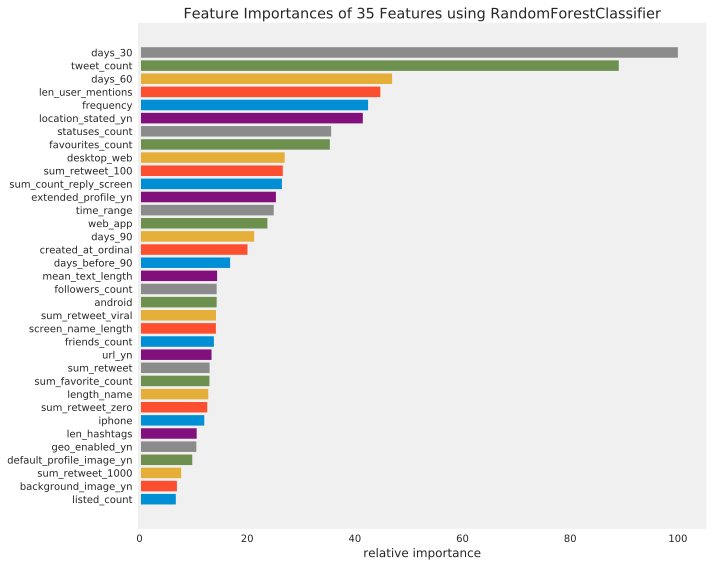

In [26]:
decisiontree = RandomForestClassifier()

decisiontree.fit(X_resampled, y_resampled)

feature_imp(y_val, X_val, decisiontree)

Confusion Matrix:
[[7850  591]
 [ 777  848]]
Precision: 0.5893,   Recall: 0.5218, F1 Score: 0.5535
ROC AUC score =  0.8846486653969181


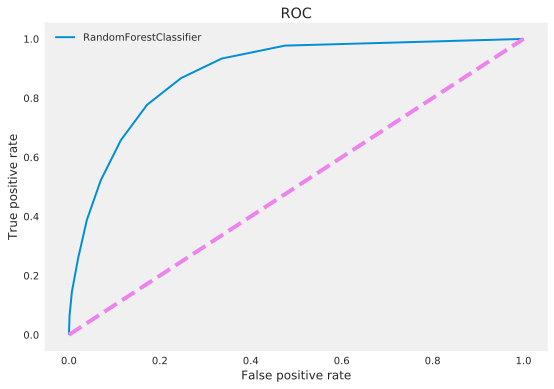

In [27]:
get_metrics(y_val, X_val, decisiontree)

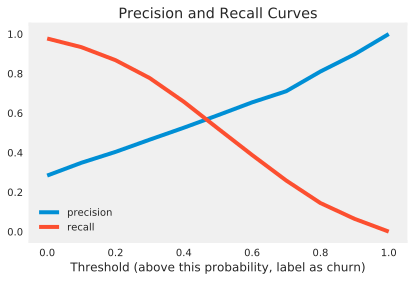

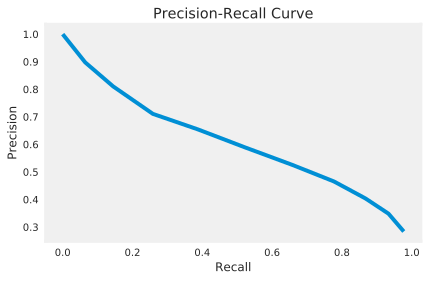

In [28]:
precision_recall(y_val, X_val,decisiontree)

Let's fit a Lasso and see if we can do any more regularization

Confusion Matrix:
[[7895  546]
 [ 807  818]]
Precision: 0.5997,   Recall: 0.5034, F1 Score: 0.5473
ROC AUC score =  0.8872314071427919


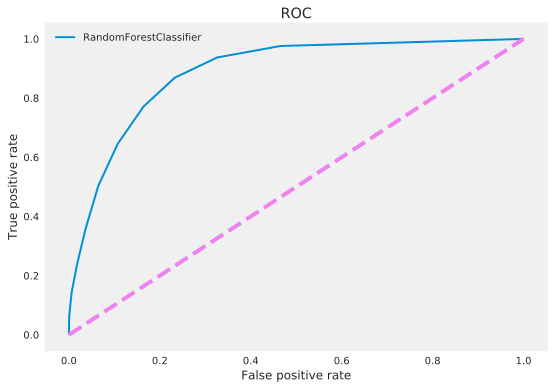

In [13]:
get_metrics(y_val, X_val, decisiontree)

<a class="anchor" id="FS_lasso"></a>

## Feature Selection with Lasso

[Table of Contents](#TOC)

In [29]:
# create a standardization
std = StandardScaler()

lml = LogisticRegression(solver='liblinear',penalty='l1',random_state=42, C = 1)
lml.fit(std.fit_transform(X_resampled), y_resampled)

predict = lml.predict(std.transform(X_val))

lml.score(std.transform(X_val), y_val)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  import sys
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


0.7446850784820187

In [ ]:
fig = plt.figure()
fig, ax = plt.subplots(figsize=(10, 8))
plt.grid(False)

viz = FeatureImportances(model)
viz.fit(X_val, y_val)
viz.show()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:195: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


<Figure size 432x288 with 0 Axes>

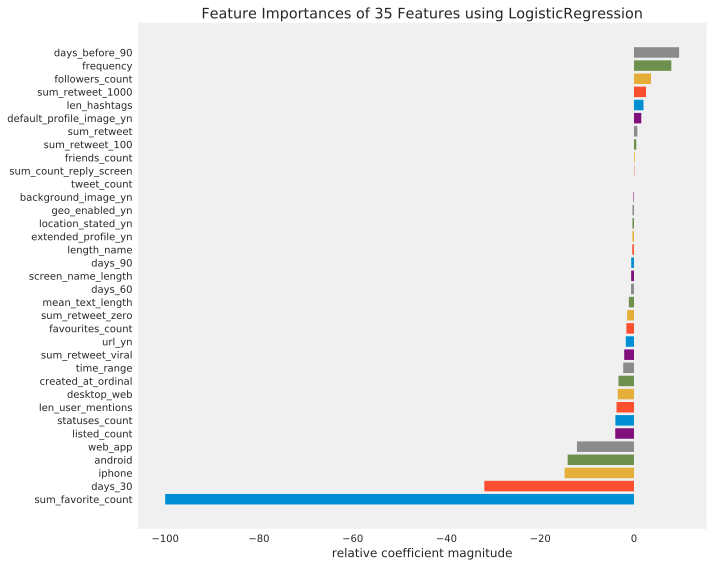

In [30]:
feature_imp(y_val,X_val,lml)

In [15]:
lod = []

for j in range(lml.coef_.shape[1]):
    lod.append({X_subset2[j], pd.DataFrame(lml.coef_ /std.scale_).T[0][j]})

lod

[{0.0, 'tweet_count'},
 {-0.003889432074558126, 'mean_text_length'},
 {-0.02114852044734244, 'android'},
 {-0.020950398791645144, 'iphone'},
 {-0.01148585317911728, 'desktop_web'},
 {-0.034297673946751796, 'web_app'},
 {0.00014998522869811017, 'sum_count_reply_screen'},
 {3.623926164317832e-08, 'sum_retweet'},
 {-0.0013096744283832955, 'sum_favorite_count'},
 {-0.0024666991012932387, 'sum_retweet_zero'},
 {0.0013701544440108827, 'sum_retweet_100'},
 {0.01469277872588321, 'sum_retweet_1000'},
 {-0.007576567859567798, 'sum_retweet_viral'},
 {0.003718879543448438, 'len_hashtags'},
 {-0.003229852221621376, 'len_user_mentions'},
 {-0.05241676545561564, 'days_30'},
 {-0.0028264591123231386, 'days_60'},
 {0.45198217276233965, 'default_profile_image_yn'},
 {-0.027884063709039796, 'background_image_yn'},
 {-0.022099591700739985, 'screen_name_length'},
 {-3.60847754270095e-05, 'statuses_count'},
 {-0.4408569087161746, 'url_yn'},
 {-0.00023429618981964687, 'time_range'},
 {0.05548088529866756, 'f

<a class="anchor" id="fs_ridge"></a>

## Feature Selection with Ridge

[Table of Contents](#TOC)

In [25]:
lml = LogisticRegression(solver='liblinear',penalty='l2',random_state=42, C = 1)
lml.fit(std.transform(X_resampled), y_resampled)

predict = lml.predict(std.transform(X_val))

lml.score(std.transform(X_val), y_val)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  


0.7460758990661633

/home/ubuntu/anaconda3/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:195: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


<Figure size 432x288 with 0 Axes>

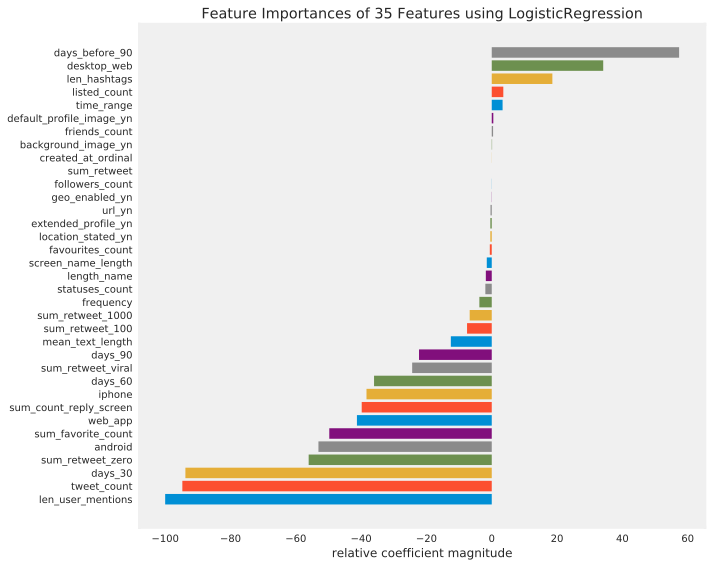

In [29]:
feature_imp(y_val,X_val,lml)

In [25]:
X_subset2 = ['android','iphone', 'desktop_web', 'web_app',
            'sum_favorite_count', 'sum_retweet_zero',
                'sum_retweet_1000', 'sum_retweet_viral', 'len_hashtags',
               'len_user_mentions', 'days_30', 'default_profile_image_yn',
                 'time_range','frequency', 'favourites_count'
            , 'days_before_90', 'listed_count', 'created_at_ordinal', 'url_yn','followers_count','sum_retweet']

X = merged_df[X_subset2]

In [18]:
# getting X and Y resampled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42,
                                                  stratify=y_train)

X_resampled, y_resampled = ADASYN(random_state=42).fit_sample(X_train,y_train)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


<Figure size 432x288 with 0 Axes>

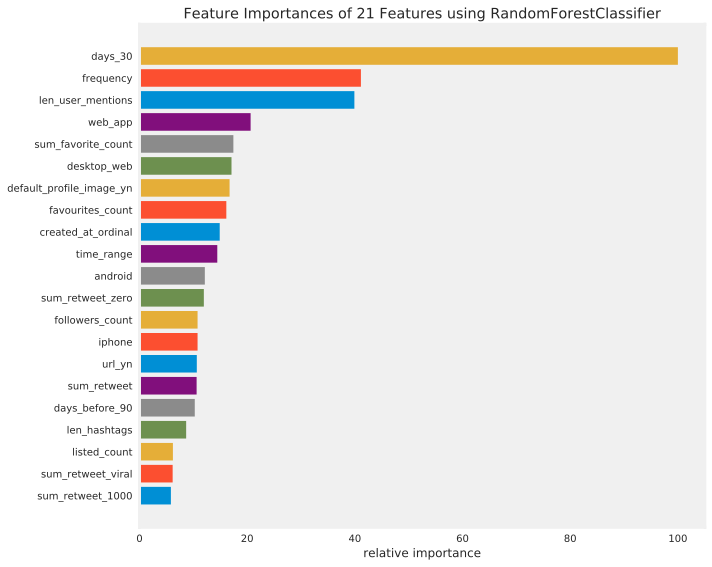

In [44]:
decisiontree = RandomForestClassifier()

decisiontree.fit(X_resampled, y_resampled)

feature_imp(y_val, X_val, decisiontree)

Confusion Matrix:
[[7835  606]
 [ 719  906]]
Precision: 0.5992,   Recall: 0.5575, F1 Score: 0.5776
ROC AUC score =  0.8905436650779621


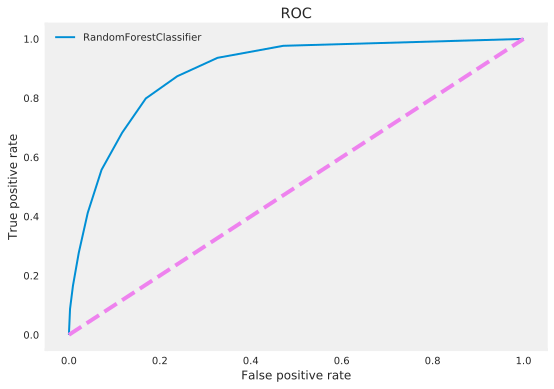

In [45]:
get_metrics(y_val, X_val, decisiontree)

<a class="anchor" id="FS_with_base"></a>

## Testing Reduced Features with Base LR

[Table of Contents](#TOC)

In [135]:
 #getting X and Y resampled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42,
                                                  stratify=y_train)

X_resampled, y_resampled = ADASYN(random_state=42).fit_sample(X_train,y_train)

In [136]:
lml = LogisticRegression(solver='liblinear',random_state=42, C = 1)
lml.fit(X_resampled, y_resampled)

predict = lml.predict(X_val)

lml.score(X_val, y_val)

0.7221339161533876

Confusion Matrix:
[[5799 2642]
 [ 155 1470]]
Precision: 0.3575,   Recall: 0.9046, F1 Score: 0.5125
ROC AUC score =  0.8820504315019184


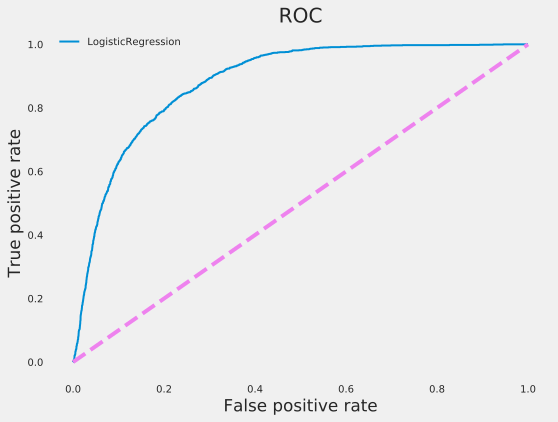

In [137]:
get_metrics(y_val, X_val, lml)

## Model Selection 

[Table of Contents](#TOC)

<a class="anchor" id="model_ten"></a>

### Model Selection - 10 models

In [46]:
# setting up the training set

X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [47]:
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

import warnings; warnings.simplefilter('ignore')

In [48]:
models = [("Logistic Regression", linear_model.LogisticRegression(solver='lbfgs')),
          ("Naïve Bayes", naive_bayes.GaussianNB()),
          ("Linear SVM", svm.LinearSVC()),
          ("Linear MLP", neural_network.MLPClassifier(activation="identity")),
          ('svm_sgd', linear_model.SGDClassifier()),
          ("Xgboost", XGBClassifier()),
          ("KNN", KNeighborsClassifier()),
          ('decisiontree', DecisionTreeClassifier()),
          ("Random Forest", RandomForestClassifier(n_estimators=100)),
          ("Relu MLP", neural_network.MLPClassifier())]
    

# setting empty list to capture score of each model
accuracy_ave = defaultdict(list)
precision_ave = defaultdict(list)
recall_ave = defaultdict(list)
f1_ave = defaultdict(list)
roc_auc_ave = defaultdict(list)

# setting up the k-fold
kf = KFold(n_splits=5, shuffle=True, random_state = 42)

for i, model_tup in enumerate(models):
           
    name, model = model_tup
    # setting up empty list to capture metrics of each k-fold split
    accuracy = defaultdict(list)
    precision = defaultdict(list)
    recall = defaultdict(list)
    f1 = defaultdict(list)
    roc_auc = defaultdict(list)
    
    # setting up number for default dict of each k-fold split
    p = 0
    for train_ind, val_ind in kf.split(X_t,y_t):
        p += 1 # add p for each k-fold
        # set train and validation data
        X_train, y_train = ADASYN(random_state=42).fit_sample(np.array(X_t)[train_ind], np.array(y_t)[train_ind])
        X_val, y_val = np.array(X_t)[val_ind], np.array(y_t)[val_ind]
  


        # fit and predict the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        # getting score of each iteration
        accuracy[p] = accuracy_score(y_val, y_pred)
        precision[p] = precision_score(y_val, y_pred) 
        recall[p] = recall_score(y_val, y_pred)
        f1[p] = f1_score(y_val, y_pred)
        roc_auc[p] = roc_auc_score(y_val, y_pred)
        
    accuracy_ave[name] = mean(accuracy[k] for k in accuracy)
    precision_ave[name] = mean(precision[k] for k in precision)
    recall_ave[name] = mean(recall[k] for k in recall) 
    f1_ave[name] = mean(f1[k] for k in f1)
    roc_auc_ave[name] = mean(roc_auc[k] for k in roc_auc)


In [49]:
import operator
sorted(accuracy_ave.items(),key=operator.itemgetter(1), reverse=True)[:5]

[('Random Forest', 0.87178110610063),
 ('Xgboost', 0.8622436973106163),
 ('decisiontree', 0.8322009876395521),
 ('Relu MLP', 0.7252417462531692),
 ('KNN', 0.7239508069394751)]

In [50]:
sorted(precision_ave.items(),key=operator.itemgetter(1), reverse=True)[:5]

[('Random Forest', 0.5996940223982559),
 ('Xgboost', 0.5571693135226958),
 ('decisiontree', 0.48312940917994907),
 ('Logistic Regression', 0.346062839523749),
 ('KNN', 0.3369991442098267)]

In [51]:
sorted(recall_ave.items(),key=operator.itemgetter(1), reverse=True)[:5]

[('Naïve Bayes', 0.9854479004663499),
 ('Logistic Regression', 0.8759664796036767),
 ('KNN', 0.7341392430579),
 ('Xgboost', 0.7132588912510733),
 ('Random Forest', 0.6181214282647391)]

In [52]:
sorted(f1_ave.items(),key=operator.itemgetter(1), reverse=True)[:5]

[('Xgboost', 0.6255881804855427),
 ('Random Forest', 0.6087323091931036),
 ('decisiontree', 0.5171418338214349),
 ('Logistic Regression', 0.4960910806992534),
 ('KNN', 0.4618929009941477)]

In [53]:
sorted(roc_auc_ave.items(),key=operator.itemgetter(1), reverse=True)[:5]

[('Xgboost', 0.8020872404156809),
 ('Logistic Regression', 0.7786506238028189),
 ('Random Forest', 0.7693479283777074),
 ('KNN', 0.7280743610527813),
 ('decisiontree', 0.7209103643187095)]

<a class="anchor" id="model_roc"></a>

## Model Selection with ROC curves

[Table of Contents](#TOC)

In [26]:
X_subset2 = ['android','iphone', 'desktop_web', 'web_app',
            'sum_favorite_count', 'sum_retweet_zero',
                'sum_retweet_1000', 'sum_retweet_viral', 'len_hashtags',
               'len_user_mentions', 'days_30', 'default_profile_image_yn',
                 'time_range','frequency', 'favourites_count'
            , 'days_before_90', 'listed_count', 'created_at_ordinal', 'url_yn','followers_count','sum_retweet']

X = merged_df[X_subset2]

In [27]:
X['sum_favorite_count'] = X['sum_favorite_count'].apply(lambda x: int(x))
# X['mean_text_length'] = X['mean_text_length'].apply(lambda x: int(x))

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42,
                                                  stratify=y_train)

X_resampled, y_resampled = ADASYN(random_state=42).fit_sample(X_train,y_train)



XGBOOST
Confusion Matrix:
[[7510  931]
 [ 442 1183]]
Precision: 0.5596,   Recall: 0.7280, F1 Score: 0.6328
ROC AUC score =  0.9106333008301969


RANDOM FOREST
Confusion Matrix:
[[7792  649]
 [ 641  984]]
Precision: 0.6026,   Recall: 0.6055, F1 Score: 0.6041
ROC AUC score =  0.9123816171981082


LOGISTIC REGRESSION
Confusion Matrix:
[[5740 2701]
 [ 208 1417]]
Precision: 0.3441,   Recall: 0.8720, F1 Score: 0.4935
ROC AUC score =  0.8477806311683813


NAÏVE BAYES
Confusion Matrix:
[[1963 6478]
 [  20 1605]]
Precision: 0.1986,   Recall: 0.9877, F1 Score: 0.3307
ROC AUC score =  0.8322264040899273


RELU MLP
Confusion Matrix:
[[8439    2]
 [1623    2]]
Precision: 0.5000,   Recall: 0.0012, F1 Score: 0.0025
ROC AUC score =  0.8016054969790308


KNN
Confusion Matrix:
[[6089 2352]
 [ 450 1175]]
Precision: 0.3331,   Recall: 0.7231, F1 Score: 0.4561
ROC AUC score =  0.7699161783602015


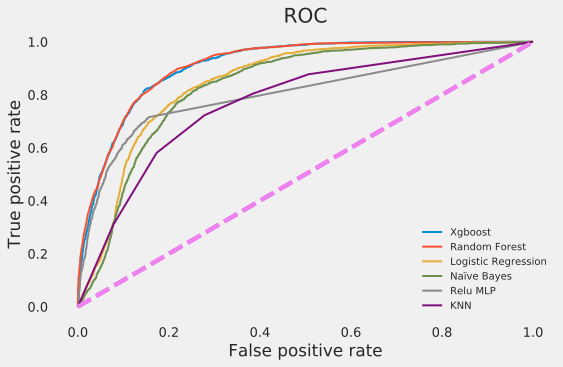

In [30]:
models = [("Xgboost", XGBClassifier()),
          ("Random Forest", RandomForestClassifier(n_estimators=100)),
          ("Logistic Regression", linear_model.LogisticRegression(solver='lbfgs')),
          ("Naïve Bayes", naive_bayes.GaussianNB()),
          ("Relu MLP", neural_network.MLPClassifier()),
          ("KNN", KNeighborsClassifier())]

kf = KFold(n_splits=5, shuffle=True, random_state = 42)

fig= plt.subplots(figsize=(8,5))

for i, model_tup in enumerate(models):
           
    name, model = model_tup
    
    # fit and predict the model
    model.fit(X_resampled, y_resampled)
    print('\n')
    print(name.upper())
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, model.predict(np.array(X_val))))

    print("Precision: {:6.4f},   Recall: {:6.4f}, F1 Score: {:6.4f}".\
          format(precision_score(y_val, model.predict(np.array(X_val))), 
                 recall_score(y_val, model.predict(np.array(X_val))), 
                 f1_score(y_val, model.predict(np.array(X_val)))))

    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(np.array(X_val))[:,1])

    plt.grid(False)
    plt.plot(fpr, tpr,label=name,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.tick_params(labelsize=13)
    plt.legend()

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC');
    print("ROC AUC score = ", roc_auc_score(y_val, model.predict_proba(np.array(X_val))[:,1]))
    ;


<a class="anchor" id="test_model"></a>

## Test Select (XGBoost) Model

[Table of Contents](#TOC)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                random_state=42, stratify=y)

X_resampled, y_resampled = ADASYN(random_state=42).fit_sample(np.array(X_train),np.array(y_train))


In [12]:
xgb_model = XGBClassifier()



Confusion Matrix:
[[9352 1199]
 [ 629 1402]]
Precision: 0.5390,   Recall: 0.6903, F1 Score: 0.6054
ROC AUC score =  0.9066203305685391


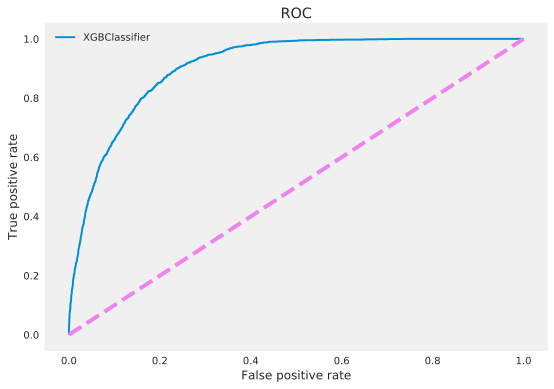

In [13]:
xgb_model.fit(X_resampled, y_resampled)
print('\n')
# print(name.upper())
get_metrics(y_test,np.array(X_test), xgb_model)
# xgb_model.predict(np.array(X_val))

In [15]:
!mkdir -p predictor

In [16]:
# saving the model
with open("predictor/xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

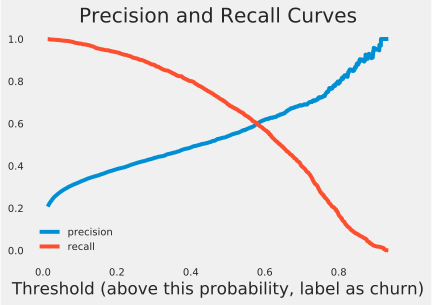

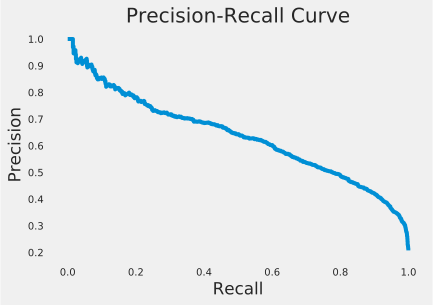

In [127]:
precision_recall(y_test, np.array(X_test), xgb_model)

In [17]:
X_test


,android,iphone,desktop_web,web_app,sum_favorite_count,sum_retweet_zero,sum_retweet_1000,sum_retweet_viral,len_hashtags,len_user_mentions,...,default_profile_image_yn,time_range,frequency,favourites_count,days_before_90,listed_count,created_at_ordinal,url_yn,followers_count,sum_retweet
56830,22,151,0,0,16,87,15,62,32,173,...,0,588,0.294218,661.0,167,0.0,736581,0,9.0,849032
29838,6,0,1,0,0,7,0,0,0,10,...,0,941,0.007439,39.0,4,0.0,734260,1,34.0,0
51285,124,0,36,1,217,189,0,0,47,25,...,0,463,0.431965,547.0,179,0.0,736317,1,100.0,14
53955,0,1,0,0,0,1,0,0,0,2,...,1,0,0.000000,0.0,0,0.0,736446,0,1.0,0
49562,1,71,38,10,317,77,1,0,119,137,...,0,722,0.166205,281.0,96,10.0,736230,1,800.0,306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51201,5,1,0,0,5,4,0,1,0,6,...,0,1041,0.005764,1183.0,1,0.0,736313,0,19.0,23983
48816,0,195,0,0,67,120,12,54,62,186,...,0,430,0.453488,3168.0,138,0.0,736190,0,38.0,1196771
19900,0,4,9,41,9,64,0,0,0,85,...,0,2840,0.023592,5.0,9,0.0,734031,0,13.0,4
41776,35,0,1,0,12,8,4,21,8,39,...,0,2058,0.017979,69.0,28,0.0,734547,0,17.0,761127


In [133]:
from ipywidgets import interact

# Create a widget to show confusion matrix and the precision and recall scores given a sliding threshold value as an input
@interact(thresh=(0, 1, .01))
def xgb_confusion(thresh):
    y_predict = (xgb_model.predict_proba(np.array(X_test))[:, 1] > thresh)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    f1 = 2* ((precision*recall) / (precision + recall))
    xgb_confusion = confusion_matrix(np.array(y_test), y_predict)
    
    plt.figure(dpi=150)
    ax = sns.heatmap(xgb_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g',
           xticklabels=['Active', 'Churn'],
           yticklabels=['Active', 'Churn'])
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('XGBoost Confusion Matrix');
    
    return 'Threshold: ' + str(thresh), "Precision: {:6.4f},   Recall: {:6.4f},    F1: {:6.4f}".format(precision, recall, f1)

interactive(children=(FloatSlider(value=0.0, description='thresh', max=1.0, step=0.01), Output()), _dom_classe…

<Figure size 432x288 with 0 Axes>

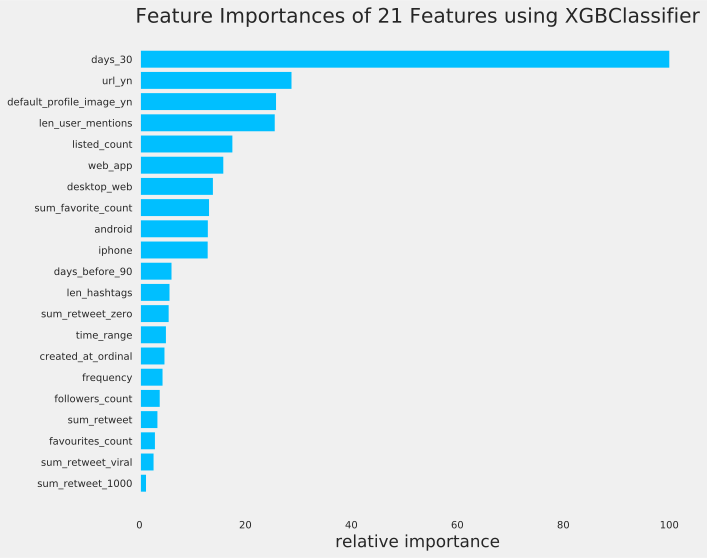

In [85]:
fig = plt.figure()
fig, ax = plt.subplots(figsize=(10, 8))
plt.grid(False)

c = ['deepskyblue']
viz = FeatureImportances(xgb_model, colors=c)
viz.fit(X_val, y_val)
viz.show();

<Figure size 432x288 with 0 Axes>

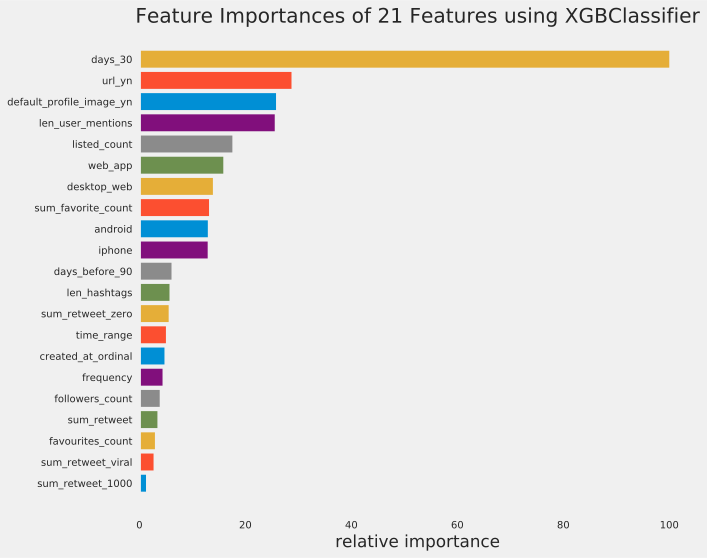

In [81]:
feature_imp(y_test,X_test,xgb_model)

<a class="anchor" id="save_model"></a>

## Saving Proba to Entire Dataset

[Table of Contents](#TOC)

In [64]:
probs = xgb_model.predict_proba(np.array(X))

In [65]:
p = pd.DataFrame(probs)

In [66]:
p.columns=['prob_active','prob_churn']

In [68]:
predicted = pd.concat([merged_df, p], axis=1)

In [69]:
predicted.to_csv('twitter_predict2.csv')